In [1]:
import os
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import shutil
import seaborn
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report


In [2]:
# src_path: input the path of the folder, where the whole data is stored
# label_path: dataframe which includes label data

src_path="C:/MA_Yijie_Ma/0_Datensatz/0_Training_Datensatz/1_40_Spulen/TrainingsDatensatz"
label_path = os.path.join(src_path, "40_Spulen_MultiLabel_v1.csv")
saveModel_path = "D:/MA_Yijie_Ma/0_Datensatz/0_Training_Datensatz/1_40_Spulen/Modelle/VGG16_MultiOutput_v1.hdf5"
#save_logs_path = "D:/MA_Yijie_Ma/0_Datensatz/0_Training_Datensatz/1_40_Spulen/Logs/MultiOuput_Inception_4Outputs_v1_logs"



In [3]:
# Using pretrained ResNet50 in the head of the Networks
pre_trained_model = VGG16(input_shape=(224, 224, 3),
                                include_top=False,
                                weights="imagenet")

for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer("block4_pool")
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation="relu")(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add 4 final sigmoid layer for classification

inOrdnung = layers.Dense(1, activation = 'sigmoid', name="0_inOrdnung")(x)
Doppelwindung = layers.Dense(1, activation = 'sigmoid', name = "1_Doppelwindung")(x)
Luecke = layers.Dense(1, activation = 'sigmoid', name = "2_Luecke")(x)
Kreuzung = layers.Dense(1, activation = 'sigmoid', name = "3_Kreuzung")(x)
    

model = Model(pre_trained_model.input, [inOrdnung, Doppelwindung, Luecke, Kreuzung])
model.compile(optimizer=RMSprop(lr = 0.0001, decay = 1e-6),
              loss = ["binary_crossentropy","binary_crossentropy","binary_crossentropy","binary_crossentropy"],
              metrics = ["accuracy"])


model.summary()

last layer output shape:  (None, 14, 14, 512)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_________________________________________

In [4]:
df = pd.read_csv(label_path)

###.....................................................

df = df.sample(frac=1, random_state=1223).reset_index(drop=True)

###.....................................................

columns=["0_inOrdnung", "1_Doppelwindung", "2_Luecke","3_Kreuzung"]

datagen = ImageDataGenerator(rescale=1. / 255., validation_split=0.15)
# train_datagen=ImageDataGenerator(rescale=1./255.)
# valid_datagen=ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=src_path,
    x_col="Image",
    y_col=columns,
    subset="training",
    batch_size=64,
    shuffle=True,
    class_mode="raw",
    target_size=(224, 224)
    )

valid_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=src_path,
    x_col="Image",
    y_col=columns,
    subset="validation",
    batch_size=64,
    shuffle=False,
    class_mode="raw",
    target_size=(224, 224)
    )


Found 32336 validated image filenames.
Found 5706 validated image filenames.


In [8]:
def generator_wrapper(generator):
    for batch_x,batch_y in generator:
        yield (batch_x,[batch_y[:,i] for i in range(4)])

# Using EarlyStopping Callbacks 
earlystopping = EarlyStopping(
    patience=5,
    min_delta=0,
    mode='min',
    monitor='val_loss',
    restore_best_weights=True,
    verbose=1)

# Using Tesorboard Callbacks
# tensorboard_callback = TensorBoard(log_dir=save_logs_path)

# Using ReduceLROnPlateau Callbacks
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2,
                              patience=3, min_lr=0.0001)

# Using Checkpoint Callbacks
checkpoint_filepath = saveModel_path
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose=0,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch')

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

history = model.fit_generator(generator_wrapper(train_generator),
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              epochs=2000,
                              verbose=1,
                              #workers=6,
                              #use_multiprocessing=False,
                              callbacks=[earlystopping, reduce_lr, checkpoint],
                              validation_data=generator_wrapper(valid_generator),
                              validation_steps=STEP_SIZE_VALID)

Epoch 1/2000
505/505 [==============================] - ETA: 0s - loss: 2.2246 - 0_inOrdnung_loss: 0.5028 - 1_Doppelwindung_loss: 0.5135 - 2_Luecke_loss: 0.6733 - 3_Kreuzung_loss: 0.5351 - 0_inOrdnung_accuracy: 0.8512 - 1_Doppelwindung_accuracy: 0.8457 - 2_Luecke_accuracy: 0.8236 - 3_Kreuzung_accuracy: 0.8191WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000018902236558> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc

Epoch 13/2000
505/505 [==============================] - 482s 955ms/step - loss: 0.1374 - 0_inOrdnung_loss: 0.0247 - 1_Doppelwindung_loss: 0.0250 - 2_Luecke_loss: 0.0471 - 3_Kreuzung_loss: 0.0407 - 0_inOrdnung_accuracy: 0.9916 - 1_Doppelwindung_accuracy: 0.9912 - 2_Luecke_accuracy: 0.9836 - 3_Kreuzung_accuracy: 0.9858 - val_loss: 0.1316 - val_0_inOrdnung_loss: 0.0219 - val_1_Doppelwindung_loss: 0.0156 - val_2_Luecke_loss: 0.0395 - val_3_Kreuzung_loss: 0.0546 - val_0_inOrdnung_accuracy: 0.9949 - val_1_Doppelwindung_accuracy: 0.9949 - val_2_Luecke_accuracy: 0.9879 - val_3_Kreuzung_accuracy: 0.9786
Epoch 14/2000
505/505 [==============================] - 478s 947ms/step - loss: 0.1291 - 0_inOrdnung_loss: 0.0245 - 1_Doppelwindung_loss: 0.0244 - 2_Luecke_loss: 0.0448 - 3_Kreuzung_loss: 0.0354 - 0_inOrdnung_accuracy: 0.9920 - 1_Doppelwindung_accuracy: 0.9910 - 2_Luecke_accuracy: 0.9848 - 3_Kreuzung_accuracy: 0.9878 - val_loss: 0.1966 - val_0_inOrdnung_loss: 0.0348 - val_1_Doppelwindung_loss:

Epoch 27/2000
505/505 [==============================] - 479s 949ms/step - loss: 0.0920 - 0_inOrdnung_loss: 0.0158 - 1_Doppelwindung_loss: 0.0176 - 2_Luecke_loss: 0.0334 - 3_Kreuzung_loss: 0.0251 - 0_inOrdnung_accuracy: 0.9949 - 1_Doppelwindung_accuracy: 0.9941 - 2_Luecke_accuracy: 0.9893 - 3_Kreuzung_accuracy: 0.9914 - val_loss: 0.1129 - val_0_inOrdnung_loss: 0.0265 - val_1_Doppelwindung_loss: 0.0125 - val_2_Luecke_loss: 0.0384 - val_3_Kreuzung_loss: 0.0355 - val_0_inOrdnung_accuracy: 0.9935 - val_1_Doppelwindung_accuracy: 0.9965 - val_2_Luecke_accuracy: 0.9916 - val_3_Kreuzung_accuracy: 0.9884
Epoch 28/2000
505/505 [==============================] - 483s 957ms/step - loss: 0.0889 - 0_inOrdnung_loss: 0.0142 - 1_Doppelwindung_loss: 0.0179 - 2_Luecke_loss: 0.0305 - 3_Kreuzung_loss: 0.0263 - 0_inOrdnung_accuracy: 0.9955 - 1_Doppelwindung_accuracy: 0.9940 - 2_Luecke_accuracy: 0.9901 - 3_Kreuzung_accuracy: 0.9911 - val_loss: 0.0909 - val_0_inOrdnung_loss: 0.0226 - val_1_Doppelwindung_loss:

# Evaluate and Plot

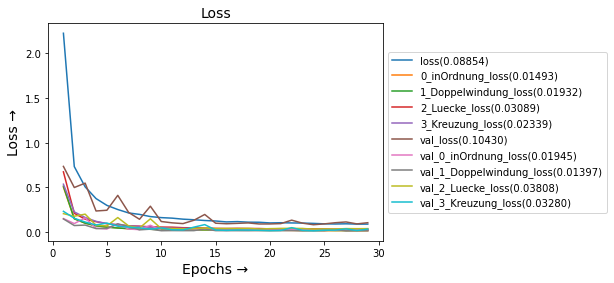

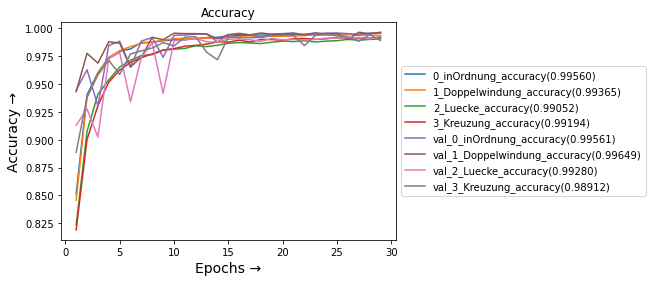

In [9]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l],  label= str(l) + '(' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l],  label= str(l) + '(' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.legend(bbox_to_anchor=(1.,.5),loc = "center left")
    plt.title("Loss", fontsize = 14)
    plt.xlabel("Epochs →", fontsize = 14)
    plt.ylabel("Loss →", fontsize = 14)
    plt.savefig("VGG16MultiOutputLoss.jpg", dpi = 300, bbox_inches = 'tight')
   
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l],  label= str(l) + '(' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l],  label= str(l) + '(' + str(format(history.history[l][-1],'.5f'))+')')

    plt.legend(bbox_to_anchor=(1.,.5),loc = "center left") 
    plt.title('Accuracy')
    plt.xlabel("Epochs →", fontsize = 14)
    plt.ylabel("Accuracy →", fontsize = 14)
    
    plt.savefig("VGG16MultiOutputAccurracy.jpg", dpi = 300, bbox_inches = 'tight')
    plt.show()
    
plot_history(history)

In [14]:
valid_generator_cm=datagen.flow_from_dataframe(
dataframe=df,
directory=src_path,
x_col="Image",
y_col=columns,
subset="validation",
batch_size=1,
shuffle=False,
class_mode="raw",
target_size=(224,224))

Y_pred = model.predict_generator(generator_wrapper(valid_generator_cm),steps=valid_generator_cm.n, verbose = 1)
Y_pred = np.squeeze(Y_pred, axis = 2)
Y_pred = (Y_pred> 0.5).astype(int).astype(float)
Y_pred = Y_pred.T

Y_true = valid_generator_cm.labels


print("the shape of Y_true is: ", Y_true.shape)
print("Y_true is: ", Y_true)
print("the shape of Y_pred is: ", Y_pred.shape)
print("Y_pred is: ", Y_pred)

Found 5706 validated image filenames.
5706/5706 [==============================] - 88s 15ms/step
the shape of Y_true is:  (5706, 4)
Y_true is:  [[1 0 1 0]
 [0 0 0 0]
 [0 0 0 0]
 ...
 [0 0 0 0]
 [1 1 1 1]
 [0 0 0 0]]
the shape of Y_pred is:  (5706, 4)
Y_pred is:  [[1. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]]


In [15]:
#draw the classification report and confusion matrix


mlcm = multilabel_confusion_matrix(Y_true, Y_pred)

print("the confusion matrix is: \n", mlcm)
print("the shape of the confusion matrix is: \n", mlcm.shape)

print("Classification Report: \n")
print(classification_report(Y_true, Y_pred))

the confusion matrix is: 
 [[[2873   13]
  [  11 2809]]

 [[3706   15]
  [  14 1971]]

 [[3193   26]
  [  24 2463]]

 [[4483   11]
  [  19 1193]]]
the shape of the confusion matrix is: 
 (4, 2, 2)
Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2820
           1       0.99      0.99      0.99      1985
           2       0.99      0.99      0.99      2487
           3       0.99      0.98      0.99      1212

   micro avg       0.99      0.99      0.99      8504
   macro avg       0.99      0.99      0.99      8504
weighted avg       0.99      0.99      0.99      8504
 samples avg       0.49      0.49      0.49      8504



C:\ProgramData\Anaconda3\envs\MA_Yijie_Ma_v1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\MA_Yijie_Ma_v1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\ProgramData\Anaconda3\envs\MA_Yijie_Ma_v1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\MA_Yijie_Ma_v1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


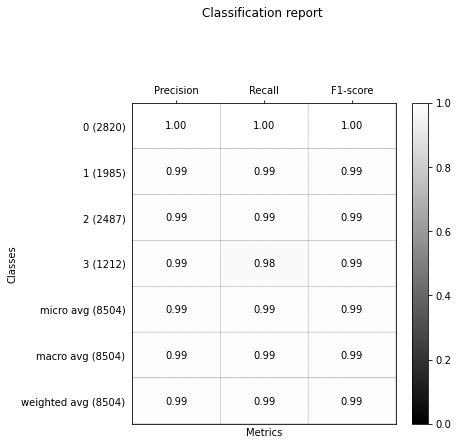

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap, vmin=0.0, vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title, y=1.25)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, number_of_classes=2, title='Classification report ', cmap='RdYlGn'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    #drop initial lines
    lines = lines[2:]

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[: number_of_classes]:
        t = list(filter(None, line.strip().split('  ')))
        if len(t) < 4: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)


    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 15
    figure_height = len(class_names) + 8
    correct_orientation = True
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
    plt.savefig("VGG16MultiOutputCR", bbox_inches='tight', dpi=300)
    plt.show()
    
    
cr = classification_report(Y_true, Y_pred)
plot_classification_report(cr, number_of_classes= 8, title='Classification report ', cmap=plt.cm.gray)

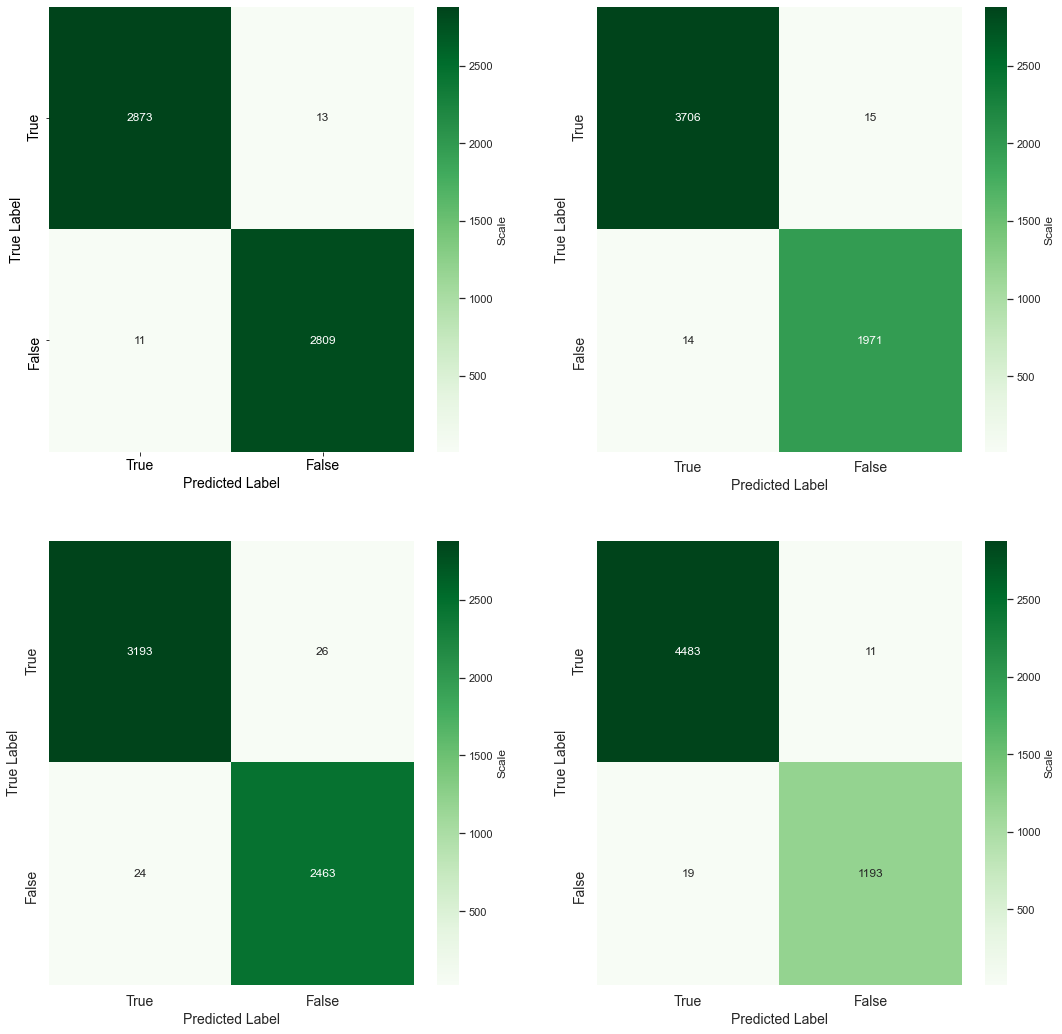

In [17]:
def plot_confusion_matrix(data, labels, title):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    #plt.figure()
 
    ax = seaborn.heatmap(data, annot=True, cmap='Greens', vmax=2880, fmt =".0f", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels, fontsize = 14)
    ax.set_yticklabels(labels, fontsize = 14)
 
    ax.set_xlabel("Predicted Label", fontsize = 14)
    ax.set_ylabel("True Label", fontsize = 14)
    #plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    #plt.close()
    #plt.imshow()
    
 
# define data
plt.figure(figsize=(18,18))
titles=["0_in Ordnung", "1_Doppelwindung", "2_Luecke", "3_Kreuzung"]

for i in range(4):
    plt.subplot(2,2,i+1)
    data = mlcm[i,:,:] 
    title = titles[i]
    # define labels
    labels = ["True", "False"]

    # create confusion matrix
    plot_confusion_matrix(data, labels, title)


plt.imshow
plt.savefig("VGG16MultiOutputConfusionMatrix", bbox_inches='tight', dpi=300)